In [1]:
import pandas as pd
import numpy as np
from ape import chain, Contract, networks

In [2]:
networks.parse_network_choice('ethereum:mainnet:alchemy').__enter__()

<alchemy chain_id=1>

In [3]:
mim_curve_pool = Contract("0x5a6A4D54456819380173272A5E8E9B9904BdF41B")
mim_curve_pool

<Vyper_contract 0x5a6A4D54456819380173272A5E8E9B9904BdF41B>

In [4]:
base_curve_pool = Contract("0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7")
base_curve_pool

<Vyper_contract 0xbEbc44782C7dB0a1A60Cb6fe97d0b483032FF1C7>

In [5]:
# A = 2000
A = mim_curve_pool.A()
A

2000

In [6]:
PRECISION = 10**18
total_supply = mim_curve_pool.totalSupply()
D = mim_curve_pool.get_virtual_price() * total_supply / PRECISION

In [7]:
# D ~ 98.534M
D /= PRECISION
D

100466303.62369576

In [8]:
# get the balances for mim and 3crv
# mim is coin0, 3crv is coin1
coin0_addr = mim_curve_pool.coins(0)
coin1_addr = mim_curve_pool.coins(1)

print(f"coin 0: {coin0_addr}")
print(f"coin 1: {coin1_addr}")

coin 0: 0x99D8a9C45b2ecA8864373A26D1459e3Dff1e17F3
coin 1: 0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490


In [9]:
mim = Contract(coin0_addr)
mim

<MagicInternetMoneyV1 0x99D8a9C45b2ecA8864373A26D1459e3Dff1e17F3>

In [10]:
crv3 = Contract(coin1_addr)
crv3

<3Crv 0x6c3F90f043a72FA612cbac8115EE7e52BDe6E490>

In [11]:
bal_mim = mim_curve_pool.balances(0) / (10 ** mim.decimals()) # adjust for decimals
bal_3crv = mim_curve_pool.balances(1) / (10 ** crv3.decimals())

print(f"balance 0 (MIM): {bal_mim}")
print(f"balance 1 (3Crv): {bal_3crv}")

balance 0 (MIM): 54721255.375546455
balance 1 (3Crv): 44722235.718086705


In [12]:
# some stableswap fns for two coin case
def _d():
    return bal_mim + bal_3crv

def B(x):
    return _d() * (1 - 4*A) * x + 4*A*(x**2)

def E(x):
    return 4*A*x

def y(x):
    return (-B(x) + np.sqrt(B(x)**2 + (_d()**3) * E(x))) / (2 * E(x))

def p(x):
    return (y(x) / x) * ((_d()**3) + 16 * A * (x**2) * (y(x))) / ((_d()**3) + 16 * A * (x) * (y(x)**2))

In [13]:
# about in line with current balance of 3crv in pool
print('y(bal_mim):', y(bal_mim))
print('y(bal_mim) / bal_3crv - 1:', y(bal_mim) / bal_3crv - 1)

y(bal_mim): 44722362.64091567
y(bal_mim) / bal_3crv - 1: 2.8380251329007677e-06


In [38]:
# plot price for mim balances
xs = np.linspace(1000000, _d(), 100000)
prices = [ p(x) for x in xs ]
df = pd.DataFrame(data={'x': xs, 'price': prices})

<AxesSubplot: xlabel='x'>

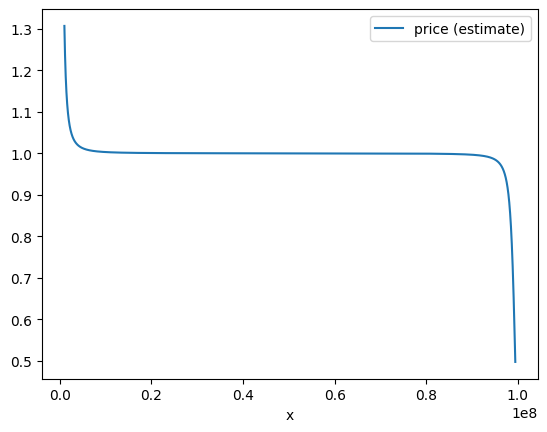

In [39]:
df.plot(x='x', y='price', label='price (estimate)')

<AxesSubplot: xlabel='x'>

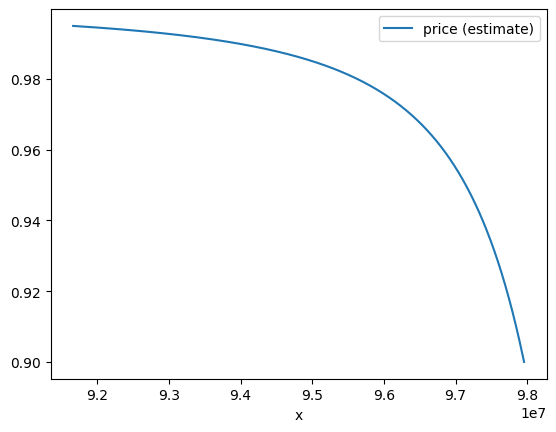

In [41]:
# zoom in near larger mim balance values for transition away from price of 1
df[(df['price'] < 0.995) & (df['price'] > 0.9)].plot(x='x', y='price', label='price (estimate)')

In [58]:
# get the inverse from linspace eval
df[abs(df['price'] - 0.9759) < 0.00005]

,x,price
96487,9.598612e+07,0.975946
96488,9.598711e+07,0.975933
96489,9.598809e+07,0.975920
96490,9.598907e+07,0.975908
96491,9.599006e+07,0.975895
96492,9.599104e+07,0.975882
96493,9.599203e+07,0.975869
96494,9.599301e+07,0.975856


In [64]:
# dx is estimated amount of MIM need to sell into pool to push price below strike
dx = df[abs(df['price'] - 0.9759) < 0.00005].iloc[-1].x - bal_mim
dx

41271756.85046619